# FACEBOOK ADS

#### For more information you can check the link below:
#### https://developers.facebook.com/docs/marketing-api/targeting-search/

In [1]:
pip install facebook-business

Note: you may need to restart the kernel to use updated packages.


In [2]:
# -*- coding: utf-8 -*-
__author__ = "Carolina Coimbra"

from facebook_business.adobjects.adaccount import AdAccount
from facebook_business.adobjects.adset import AdSet
from facebook_business.adobjects.targetingsearch import TargetingSearch
from facebook_business.api import FacebookAdsApi
from facebook_business.exceptions import FacebookError
from unicodedata import normalize

import numpy as np
import matplotlib.pyplot as plt
import string
import pandas as pd
import time

## FUNCTIONS TO MAKE REQUESTS

In [3]:
# Initialize the account

# PLEASE, UPDATE THE VERSION IF NECESSARY!

def get_ad_account(token, act_id, secret):

    if secret != '-':
        facebook_api = FacebookAdsApi.init(access_token=token, app_secret=secret, api_version='v7.0') #version
    else:
        facebook_api = FacebookAdsApi.init(access_token=token, api_version='v7.0') #version

    account = AdAccount('act_' + act_id)
    
    return facebook_api, account

In [4]:
# Return the audience for a specific target
def make_request(account, targeting_spec):
    api_params = {
        'targeting_spec': targeting_spec
    }
    
    reach_estimate = account.get_reach_estimate(params=api_params)
    number = reach_estimate[0]['users']
    return number

In [5]:
# Return the interest id
def getInterestIDFromText(api, text, limit=10):
    params = {
        'q': text,        
        'type': 'adinterest',
        'limit': limit,        
    }
    
    resp = TargetingSearch.search(params=params, api=api)
    return resp

In [6]:
# Return the location key
def getLocationElement(api, element, location_type="country"):   
    params = {
        'q': element,
        'type': 'adgeolocation',
#       'location_types': ['city'] OR ['region'] OR ['country'] OR ['country_group'],
        'location_types': [location_type],
#       'countries': ['US']
    }
    
    responses = TargetingSearch.search(params=params, api=api)
    return responses

In [7]:
# Return a dictionary with the informations abount the interests
def testInterestSearch(api, list_of_interests_to_search): 
    
    print("interest_id \t name \t audience_size \t type")
       
    interests_dict = dict()

    for interest in list_of_interests_to_search:
        search_result = getInterestIDFromText(api, interest)
         
        for element in search_result: 
            #Consider just if the names is exactly the same!
            if interest.lower() == element["name"].lower():
                e_id = element["id"]
                e_name = interest
                e_audience = element["audience_size"]
                
                #not all responses have a topic and category defined. 
                try:
                    e_type = element["topic"]
                except:
                    e_type = ""
                interests_dict[e_name] = {"id": e_id, "audience": e_audience, "type": e_type}

                print (str(e_id) + "\t" + str(e_name) + "\t" + str(e_audience) + "\t" + str(e_type))
            
                break
          
    return interests_dict


In [8]:
# Return a dictionary with the informations abount the locations
def testSearchForLocationCode(api, list_of_locations_and_types_to_search):
    #available location types: country, country_group, region, city,

    print("key \t name \t location_type")
    
    locations_dict = dict()
    
    for location, l_type in list_of_locations_and_types_to_search:
        search_result = getLocationElement(api, location, location_type = l_type)  
        
        for element in search_result:
            if location == element["name"]:
                e_key = element["key"]
                e_name = element["name"]
                e_type = element["type"]

                locations_dict[e_name] = {"key": e_key, "type": e_type}

                print (str(e_key) + "\t" + str(e_name) + "\t" + str(e_type))
            
            break        
            
    return locations_dict

## INITIALIZE YOUR ACCOUNT

In [9]:
#COMPLETE YOUT TOKEN
token = "YOUR TOKEN HERE"
#COMPLETE YOUR ACT ID
act_id = "YOUR ACT ID HERE"
secret = "-"
  
facebook_api, account = get_ad_account(token, act_id, secret)

## EXAMPLES:

### Collecting some interests id

In [11]:
#In my case, the names are in Portuguese
list_of_interests_to_search = ['feijoada', 'pretzel', 'pizza']

In [12]:
print("INTERESTS TO SEARCH:")
interests_dict = testInterestSearch(facebook_api, list_of_interests_to_search)

INTERESTS TO SEARCH:
interest_id 	 name 	 audience_size 	 type
6003131205636	feijoada	3417610	Food and drink
6003130694636	pretzel	7217780	Food and drink
6003668857118	pizza	519362570	Food and drink


In [13]:
interests_dict

{'feijoada': {'id': '6003131205636',
  'audience': 3417610,
  'type': 'Food and drink'},
 'pretzel': {'id': '6003130694636',
  'audience': 7217780,
  'type': 'Food and drink'},
 'pizza': {'id': '6003668857118',
  'audience': 519362570,
  'type': 'Food and drink'}}

### Collecting some locations key

In [14]:
#In my case, the names are in Portuguese
list_of_locations_to_search = [('Brazil', 'country'), ('Germany', 'country'), ('Italy', 'country')]

In [15]:
print("LOCATIONS TO SEARCH:")
locations_dict = testSearchForLocationCode(facebook_api, list_of_locations_to_search)

LOCATIONS TO SEARCH:
key 	 name 	 location_type
BR	Brazil	country
DE	Germany	country
IT	Italy	country


In [16]:
locations_dict

{'Brazil': {'key': 'BR', 'type': 'country'},
 'Germany': {'key': 'DE', 'type': 'country'},
 'Italy': {'key': 'IT', 'type': 'country'}}

### Defining your target
#### In this example we want all the Facebook users who are between 13 and 65+ years old.

In [17]:
targeting_spec = {
    "publisher_platforms": ["facebook"], #facebook, instagram
    "facebook_positions": ["feed"], #feed, right_hand_column, instream_video
    "age_min": 13, #The min age default is 18, so I've changed to 13. The max age default is 65+
    "excluded_publisher_categories": [],
    "excluded_publisher_list_ids": [],
    "user_device": [],
    "excluded_user_device": [],
    "user_os": [],
    "wireless_carrier": [],
    'behaviors': [],
    'interests': [],
    "flexible_spec": []        
}

### Collecting the audience in each country

In [18]:
for location in locations_dict:
    #Adding the information about the location of our target
    if locations_dict[location]["type"] == "country":
        targeting_spec["geo_locations"] = {"countries":[locations_dict[location]["key"]]}
    else:
        targeting_spec["geo_locations"] = {"regions":[{"key":locations_dict[location]["key"]}]}
    
    #We will not specify interests because we are interested on the country audience
    targeting_spec["interests"] = []
        
    audience_size = make_request(account,targeting_spec)
    
    print ("Population in " + str(location) + " = " + str(audience_size))
    
    locations_dict[location]["audience"] = audience_size

Population in Brazil = 130000000
Population in Germany = 27000000
Population in Italy = 30000000


In [19]:
locations_dict

{'Brazil': {'key': 'BR', 'type': 'country', 'audience': 130000000},
 'Germany': {'key': 'DE', 'type': 'country', 'audience': 27000000},
 'Italy': {'key': 'IT', 'type': 'country', 'audience': 30000000}}

### Collecting the audience in each interests for each country

In [20]:
dict_info = dict()

for location in locations_dict:
    
    dict_info[location] = dict()
    
    #Adding the information about the location of our target
    if locations_dict[location]["type"] == "country":
        targeting_spec["geo_locations"] = {"countries":[locations_dict[location]["key"]]}
    else:
        targeting_spec["geo_locations"] = {"regions":[{"key":locations_dict[location]["key"]}]}

    for interest in interests_dict:
        #Adding the information about the interest we are looking for
        targeting_spec["interests"] = [interests_dict[interest]["id"]]

        audience_size = make_request(account,targeting_spec)
        
        print ("Population in " + str(location) + " interested in " + str(interest) + " = " + str(audience_size))
        
        #Wait 2 seconds between requests
        time.sleep(2)

        dict_info[location][interest] = (audience_size, float(audience_size/float(locations_dict[location]["audience"])))

Population in Brazil interested in feijoada = 4000000
Population in Brazil interested in pretzel = 74000
Population in Brazil interested in pizza = 38000000
Population in Germany interested in feijoada = 4700
Population in Germany interested in pretzel = 160000
Population in Germany interested in pizza = 6700000
Population in Italy interested in feijoada = 8500
Population in Italy interested in pretzel = 110000
Population in Italy interested in pizza = 14000000


In [21]:
dict_info

{'Brazil': {'feijoada': (4000000, 0.03076923076923077),
  'pretzel': (74000, 0.0005692307692307692),
  'pizza': (38000000, 0.2923076923076923)},
 'Germany': {'feijoada': (4700, 0.00017407407407407408),
  'pretzel': (160000, 0.005925925925925926),
  'pizza': (6700000, 0.24814814814814815)},
 'Italy': {'feijoada': (8500, 0.00028333333333333335),
  'pretzel': (110000, 0.0036666666666666666),
  'pizza': (14000000, 0.4666666666666667)}}

### Plots

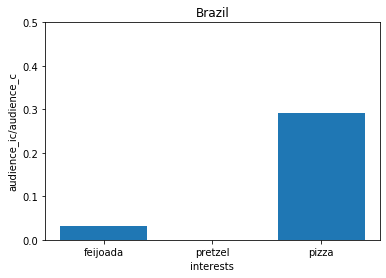

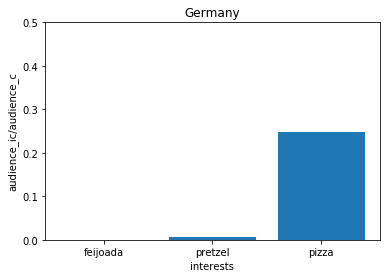

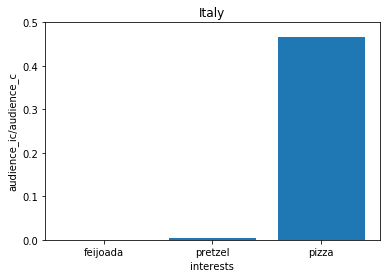

In [22]:
x_int = range(len(interests_dict))
x = interests_dict.keys()

for location in dict_info:
    y, y_norm = zip(*dict_info[location].values())
    
    plt.bar(range(len(dict_info[location])), y_norm)
    
    plt.title(location)
    plt.xticks(x_int, x)
    plt.xlabel("interests")
    plt.ylim((0,0.5))
    plt.ylabel("audience_ic/audience_c")
    
    plt.show()